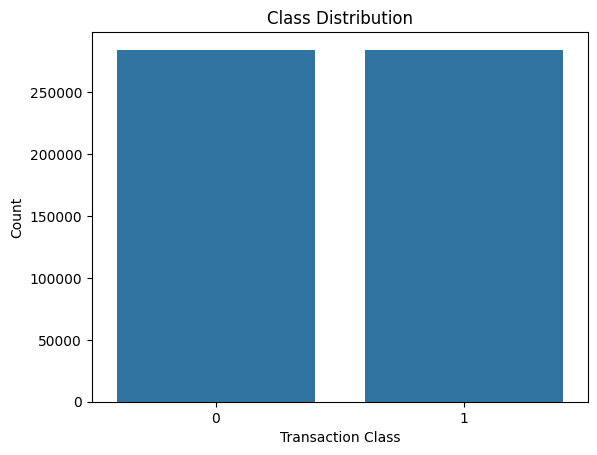

Class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#Below is us loading and exploring the dataset intially

#Read the data
df = pd.read_csv('../data/creditcard_2023.csv')

#print(df.head())
#print(df.info())
#print(df['Class'].value_counts())

#Check if this thing really is already balanced
#df['Class'].value_counts(normalize=True)

# Class distribution
sns.countplot(x='Class', data=df)
plt.title("Class Distribution")
plt.xlabel("Transaction Class")
plt.ylabel("Count")
plt.show()

# Optional: Show percentages to see the balance of the dataset
fraud_ratio = df['Class'].value_counts(normalize=True)
print(fraud_ratio)


Series([], dtype: int64)
Any missing values in dataset? False


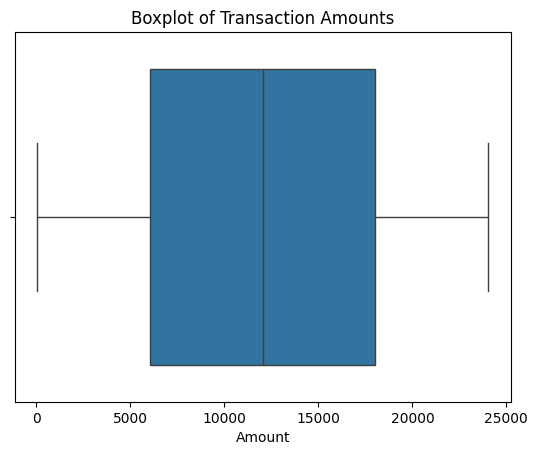

count    568630.000000
mean      12041.957635
std        6919.644449
min          50.010000
25%        6054.892500
50%       12030.150000
75%       18036.330000
max       24039.930000
Name: Amount, dtype: float64
473871    24039.93
85369     24039.93
15509     24039.88
182117    24039.85
376626    24039.82
515776    24039.76
436922    24039.61
137650    24039.55
32125     24039.55
241276    24039.53
Name: Amount, dtype: float64


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

#Visualize Class distribution

#sns.countplot(x='Class', data=df)  # Show imbalance

# Plot distributions for some V features
#df['V1'].hist(bins=50)

#df['V1'].hist(bins=50)
#plt.title("Distribution of V1")
#plt.xlabel("V1 Value")
#plt.ylabel("Frequency")
#plt.show()

#Check for any missing values within the given dataset

# Missing values per column
missing = df.isnull().sum()
print(missing[missing > 0])  # Only show columns with missing values

# Overall check
print("Any missing values in dataset?", df.isnull().values.any())

#Check and visualize any outliers
sns.boxplot(x='Amount', data=df, orient='h')
plt.title("Boxplot of Transaction Amounts")
plt.show()


#Further check, becasue this data set is definitley pre processed lol
print(df['Amount'].describe())
print(df['Amount'].sort_values(ascending=False).head(10))


In [ ]:
#Distribution of features
df['Amount'].hist(bins=50)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

#Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [38]:
#Data preprocessing and Feature preparation


from sklearn.preprocessing import StandardScaler

#Scale amount column. Keeping all features V1-V28 to a similar scale
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df[['Amount']])
# optional, to avoid duplicate info
df = df.drop(columns=['Amount'])  


#Seperate features from labels:
from sklearn.model_selection import train_test_split

#Define X and y
X = df.drop(columns=['Class', 'id'])
y = df['Class']

#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE ONLY to training data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
#Visualize fraud by amount
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Class', y='scaled_amount', data=df)
plt.title("Scaled Transaction Amounts by Class")
plt.show()

#based on this, amount isnt necessarily a strong feature for predicting fraud

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



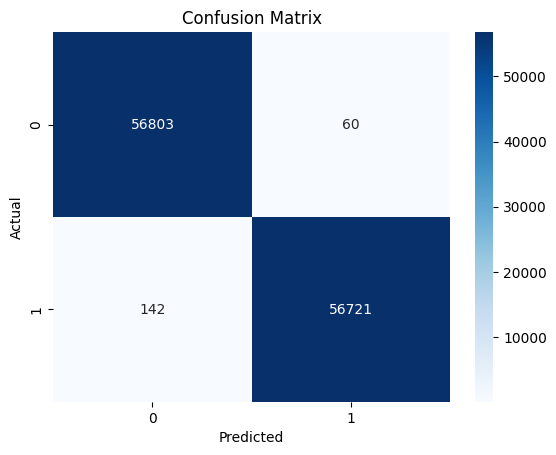

In [29]:
#Train a Logistic regression model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=5000)
model.fit(X_train_resampled, y_train_resampled)

# Step 6: Evaluate ON ORIGINAL TEST SET
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optional: Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



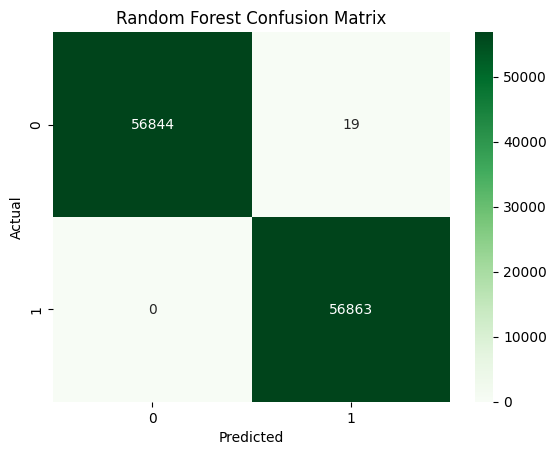

   Feature  Importance
9      V10    0.156471
13     V14    0.152410
3       V4    0.141192
11     V12    0.108731
10     V11    0.087315
16     V17    0.059593
15     V16    0.051533
6       V7    0.043577
2       V3    0.034272
1       V2    0.020122


In [39]:
#Train a radnom forest on resampled data

from sklearn.ensemble import RandomForestClassifier

# Train on SMOTE-resampled data
rf_model = RandomForestClassifier(
    n_estimators=100,         # number of trees
    random_state=42,
    class_weight='balanced'   # handles imbalance (even with SMOTE, adds safety)
)

rf_model.fit(X_train_resampled, y_train_resampled)


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_rf_pred = rf_model.predict(X_test)

# Classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_rf_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_rf_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()



##Feature importance
import pandas as pd
import numpy as np

importances = rf_model.feature_importances_
feature_names = X.columns  # original columns before train/test split

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))

